# import libraries


In [35]:
import os
import cv2
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt 
from random import shuffle , seed
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications   import EfficientNetB3
from tensorflow.keras.applications.densenet import DenseNet201 
from tensorflow.keras.layers import Input ,concatenate, Dense,Flatten ,Conv2D ,Dropout ,MaxPool2D

# Read data And Explore data

In [36]:
#read
data_path="../input/brain-tumor-classification-mri/Training"
folders=os.listdir(data_path)
print ("classes : ", folders)


# configration lists for read in it
glioma_tumor_scans=[]
glioma_tumor_labels=[]

meningioma_tumor_scans=[]
meningioma_tumor_labels=[]

pituitary_tumor_scans=[]
pituitary_tumor_labels=[]


non_tumor_scans=[]
non_tumor_labels=[]

classes :  ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']


In [37]:
# read brain glioma tumor scans
glioma_tumor_scans,glioma_tumor_labels=[cv2.imread(data_path+"/glioma_tumor/"+image) for image in tqdm(os.listdir(data_path+"/glioma_tumor"))],["Glioma Tumor" for image in tqdm(os.listdir(data_path+"/glioma_tumor"))]
print("brain glioma tumor scans number : ", len(glioma_tumor_scans))
print("brain glioma tumor labels number : ", len(glioma_tumor_labels))
 


100%|██████████| 826/826 [00:00<00:00, 872668.79it/s]

brain glioma tumor scans number :  826
brain glioma tumor labels number :  826


In [38]:
# read brain meningioma tumor scans
meningioma_tumor_scans,meningioma_tumor_labels=[cv2.imread(data_path+"/meningioma_tumor/"+image) for image in tqdm(os.listdir(data_path+"/meningioma_tumor"))],["Meningioma Tumor" for image in tqdm(os.listdir(data_path+"/meningioma_tumor"))]
print("brain meningioma tumor scans number : ", len(meningioma_tumor_scans))
print("brain meningioma tumor labels number : ", len(meningioma_tumor_labels))


100%|██████████| 822/822 [00:00<00:00, 320181.82it/s]

brain meningioma tumor scans number :  822
brain meningioma tumor labels number :  822


In [39]:
# read brain tumor scans
pituitary_tumor_scans,pituitary_tumor_labels=[cv2.imread(data_path+"/pituitary_tumor/"+image) for image in tqdm(os.listdir(data_path+"/pituitary_tumor"))],["Pituitary Tumor" for image in tqdm(os.listdir(data_path+"/pituitary_tumor"))]
print("brain pituitary tumor scans number : ", len(pituitary_tumor_scans))
print("brain pituitary tumor labels number : ", len(pituitary_tumor_labels))


100%|██████████| 827/827 [00:00<00:00, 587913.46it/s]

brain pituitary tumor scans number :  827
brain pituitary tumor labels number :  827


In [40]:
# read non tumor scans
non_tumor_scans , non_tumor_labels=[cv2.imread(data_path+"/no_tumor/"+image) for image in tqdm(os.listdir(data_path+"/no_tumor"))], ["Non Tumor" for image in tqdm(os.listdir(data_path+"/no_tumor"))]
print("non tumor scans number : ", len(non_tumor_scans))
print("non tumor labels number : ", len(non_tumor_labels))


100%|██████████| 395/395 [00:00<00:00, 677607.39it/s]

non tumor scans number :  395
non tumor labels number :  395


Text(0.5, 1.0, 'Pituitary Tumor')

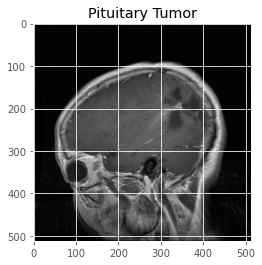

In [41]:
plt.imshow(glioma_tumor_scans[0])
plt.title(pituitary_tumor_labels[0])

In [42]:
#function to show images
def image_show(data, labels , number_of_image ):
    #to generate a random numbers
    numbers=np.random.randint(0,len(data),number_of_image)
    plt.figure(figsize=(30,20))
    j = number_of_image/10
    for _,i in enumerate(numbers):
        plt.subplot(j,10,_+1)
        plt.imshow(data[i])
        plt.title(labels[i]+"\n"+f"size {data[i].shape}")
        #to remove the number that appear around image
        plt.xticks([]),plt.yticks([])
    plt.show()



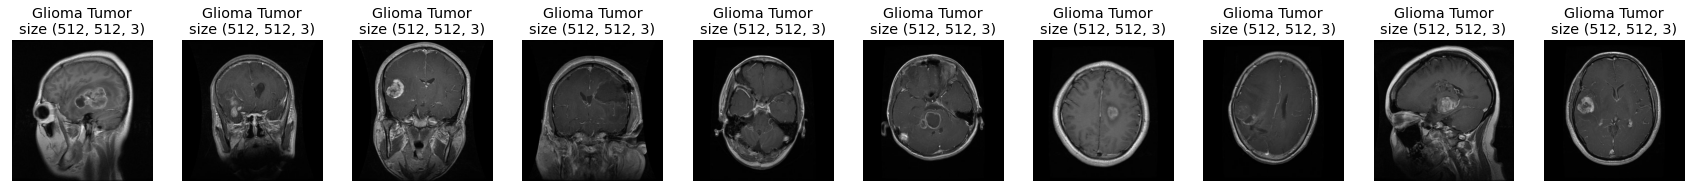

In [43]:
# show sample for  glioma_tumor_scans
image_show(glioma_tumor_scans,glioma_tumor_labels ,10)

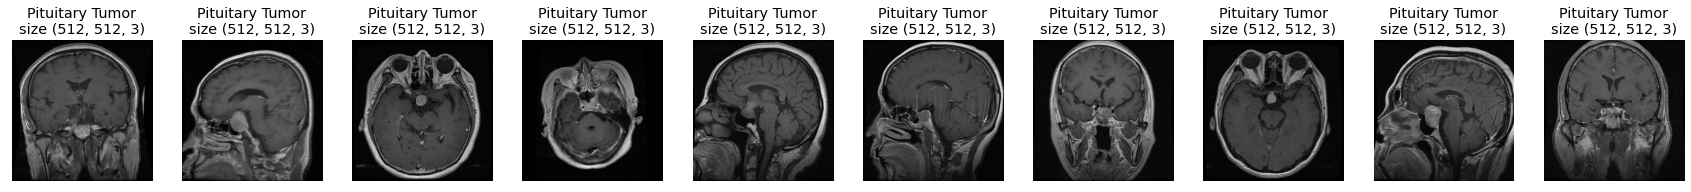

In [44]:
# show sample for non tumor scan
image_show(pituitary_tumor_scans,pituitary_tumor_labels ,10)

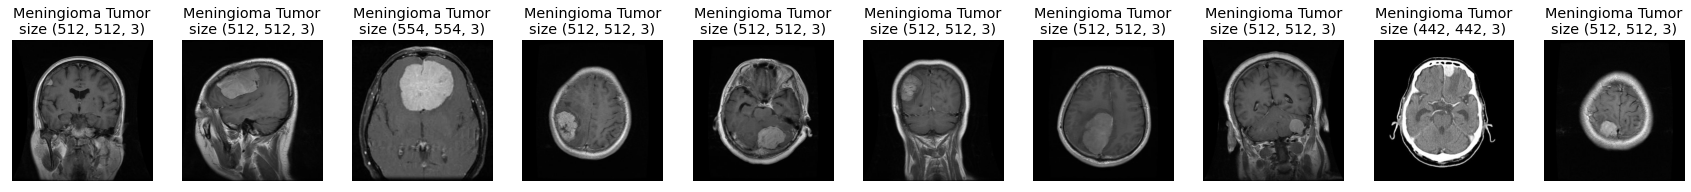

In [45]:
# show sample for  glioma_tumor_scans
image_show(meningioma_tumor_scans,meningioma_tumor_labels ,10)

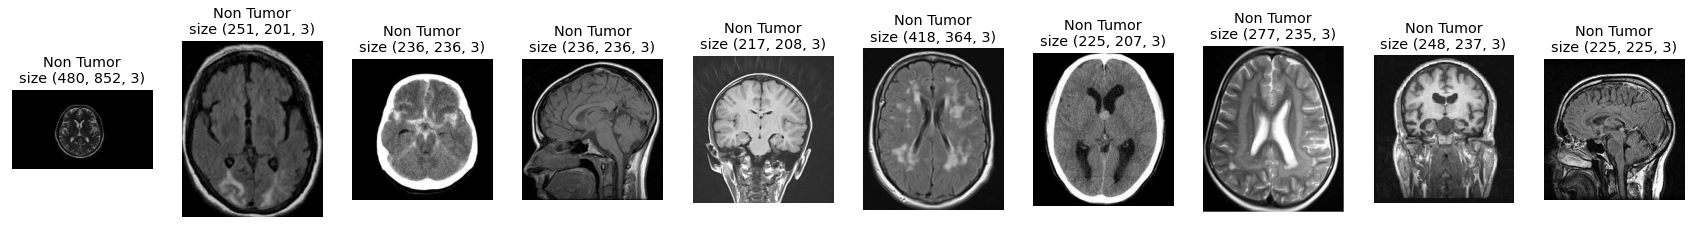

In [46]:
# show sample for non tumor scan
image_show(non_tumor_scans,non_tumor_labels ,10)

# resize images

first after show these images , we can resize the all of these image in the same size

In [47]:
# global image size
ImageSize=224

#resize tumor scans
glioma_tumor_scans=[cv2.resize(image, (ImageSize,ImageSize)) for image in glioma_tumor_scans]


#resize tumor scans
meningioma_tumor_scans=[cv2.resize(image, (ImageSize,ImageSize)) for image in meningioma_tumor_scans]


#resize tumor scans
pituitary_tumor_scans=[cv2.resize(image, (ImageSize,ImageSize)) for image in pituitary_tumor_scans]


#resize non tumor scans
non_tumor_scans=[cv2.resize(image, (ImageSize,ImageSize)) for image in non_tumor_scans]

# combine scans

In [48]:
#prepare Dataset

Scans=[]
Labels=[]


#combine scans
Scans.extend(glioma_tumor_scans)
Scans.extend(meningioma_tumor_scans)
Scans.extend(pituitary_tumor_scans)
Scans.extend(non_tumor_scans)

#combine labels
Labels.extend(glioma_tumor_labels)
Labels.extend(meningioma_tumor_labels)
Labels.extend(pituitary_tumor_labels)
Labels.extend(non_tumor_labels)

#converte to array 
Scans=np.array(Scans)
Labels=np.array(Labels)


print("Scans shape: ", Scans.shape)
print("Labels shape: ", Labels.shape)


Scans shape:  (2870, 224, 224, 3)
Labels shape:  (2870,)


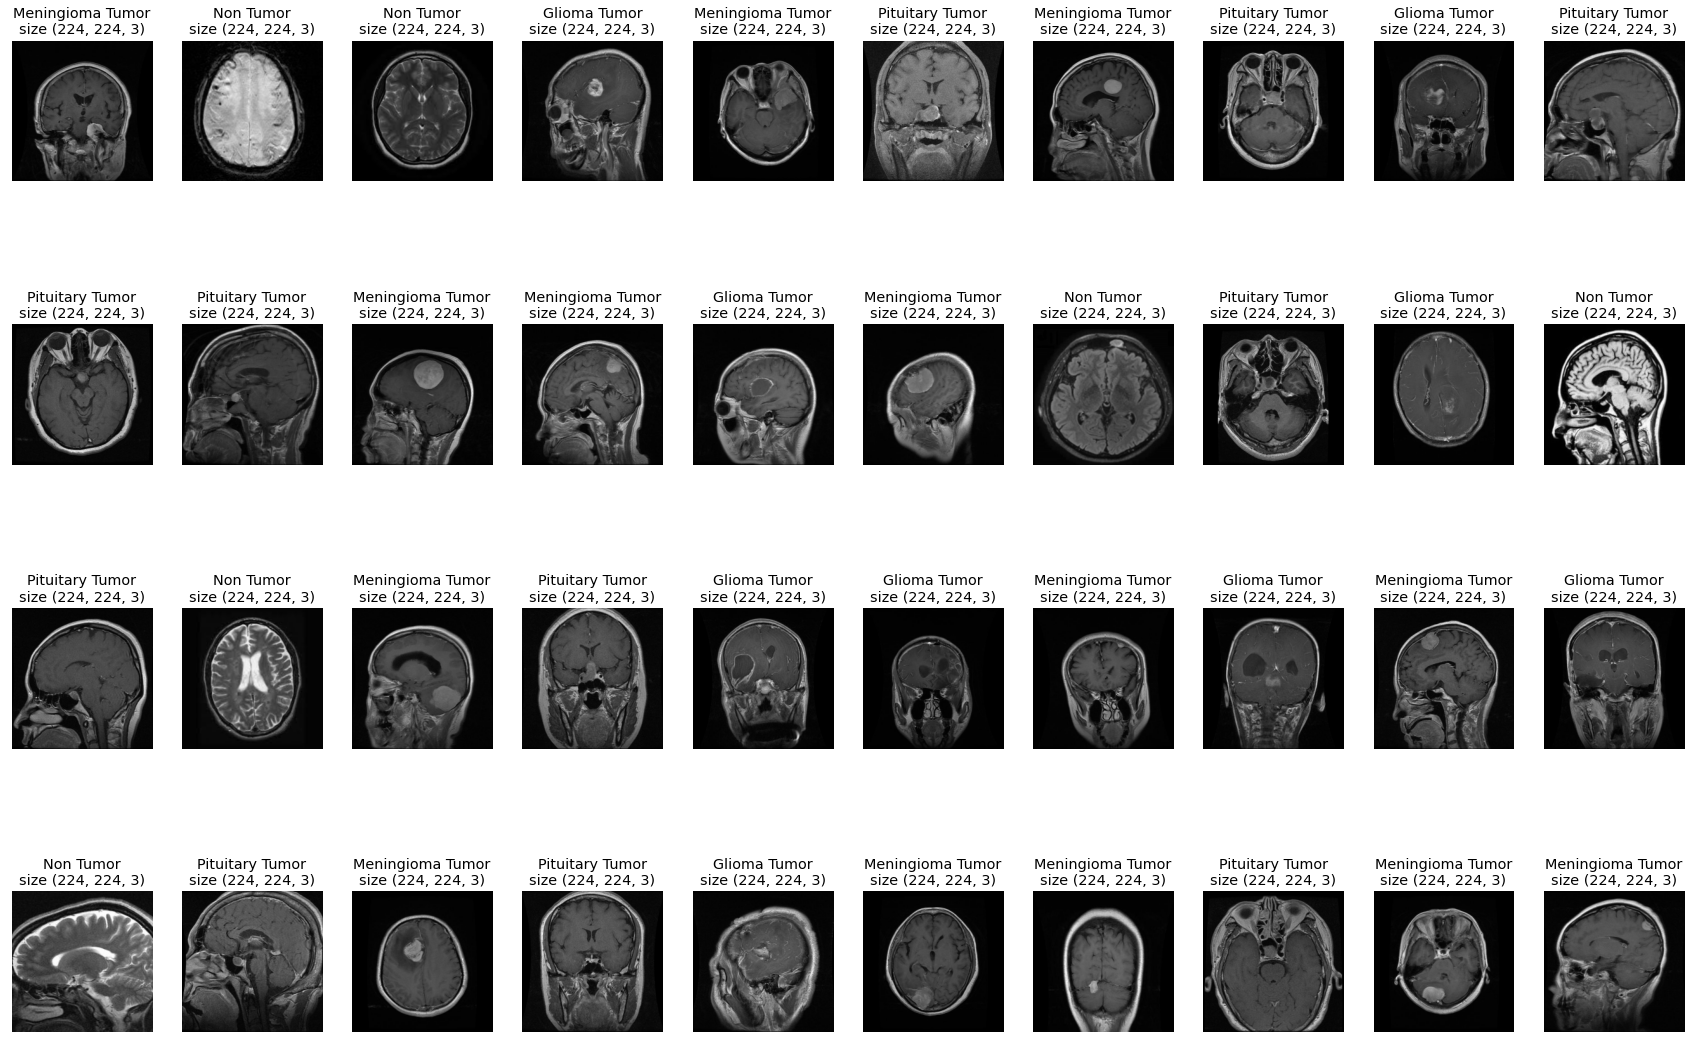

In [49]:
#### show scans after resized
# show sample for  tumor scan
image_show(Scans,Labels ,40)



In [50]:
classes={0:"Non Tumor" , 1:"Glioma Tumor" , 2:"Meningioma Tumor" , 3:"Pituitary Tumor"}
#function to get code by name 
def get_code(name):
    for key , value in classes.items():
        if value ==name:
            break
    return key

#function to get name by code
def get_class(key):
    return classes[key]


#test
print("Non Tumor :", get_code("Non Tumor"))
print("0 :" ,get_class(0))

print("Tumor :", get_code("Tumor"))
print("1 :" ,get_class(1))



Non Tumor : 0
0 : Non Tumor
Tumor : 3
1 : Glioma Tumor


In [51]:
#labels configuration

Labels=[get_code(label) for label in Labels]
Labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


# Let's see graph if there is balance in the data or not

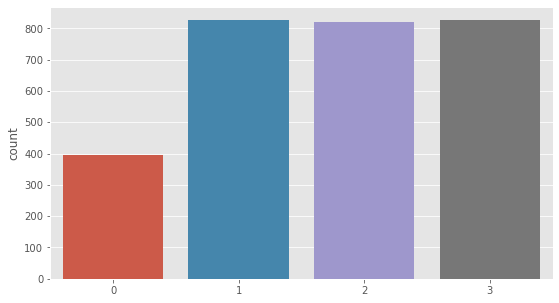

In [52]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(9,5))
sns.countplot(Labels)
plt.show()

بعد ما شفت عدم توازن في عينات الطبيعيه , انا هضيف داتا سيت تانيه عشان يحصل عندي توازن بشكل عظيم 

In [53]:
# read other non tumor scans
other_non_tumor_scans , other_non_tumor_labels=[cv2.resize(cv2.imread("../input/brain-mri-images-for-brain-tumor-detection/no/"+image),(ImageSize,ImageSize)) for image in tqdm(os.listdir("../input/brain-mri-images-for-brain-tumor-detection/no"))], ["Non Tumor" for image in tqdm(os.listdir("../input/brain-mri-images-for-brain-tumor-detection/no/"))]
print("other non tumor scans number : ", len(other_non_tumor_scans))
print("other non tumor labels number : ", len(other_non_tumor_labels))

100%|██████████| 98/98 [00:00<00:00, 51277.67it/s]

other non tumor scans number :  98
other non tumor labels number :  98


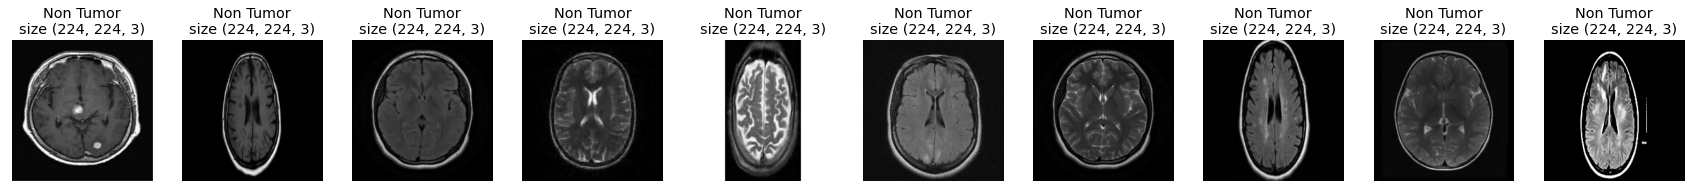

In [54]:
# show sample for  other tumor scan
image_show(other_non_tumor_scans,other_non_tumor_labels ,10)

add other non tumor to original non tumor scans

In [55]:
Scans=list(Scans) +other_non_tumor_scans
Scans=np.array(Scans)

# add labels and converte other non tumor labels to categroical
Labels=list(Labels)+ [get_code(label) for label in other_non_tumor_labels]

Labels=np.array(Labels)


print("Scans shape: ", Scans.shape)
print("Labels shape: ", Labels.shape)

Scans shape:  (2968, 224, 224, 3)
Labels shape:  (2968,)


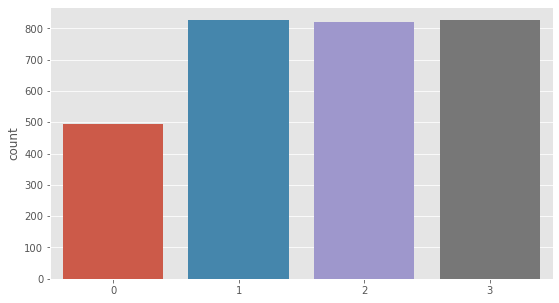

In [56]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(9,5))
sns.countplot(Labels)
plt.show()

should converte this labels to Categorical

In [57]:
import tensorflow as tf
Labels=tf.keras.utils.to_categorical(Labels, num_classes=4, dtype='float32')
Labels

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

# Split dataset

In [58]:
#split all data to train and test
x_train, x_val, y_train  , y_val=train_test_split(Scans, Labels,test_size=0.05 , shuffle=True , stratify=Labels)

print("x train shape: ", x_train.shape)
print("y train shape: ", y_train.shape)


print("x val shape: ", x_val.shape)
print("y val shape: ", y_val.shape)

x train shape:  (2819, 224, 224, 3)
y train shape:  (2819, 4)
x val shape:  (149, 224, 224, 3)
y val shape:  (149, 4)


# **Preprocessing on the images**

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator=ImageDataGenerator(
        samplewise_std_normalization=True,
        samplewise_center=True,
        rotation_range=90
,fill_mode='nearest')

batch_size=16                                               #16 for dense Net , 16 for efficient
train_generator=generator.flow(x_train,y_train ,batch_size=batch_size)
val_generator=generator.flow(x_val,y_val)

In [60]:
#get data for generator
train_scans=train_generator.__getitem__(0)[0]
train_labels=train_generator.__getitem__(0)[1]

In [61]:
train_labels

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

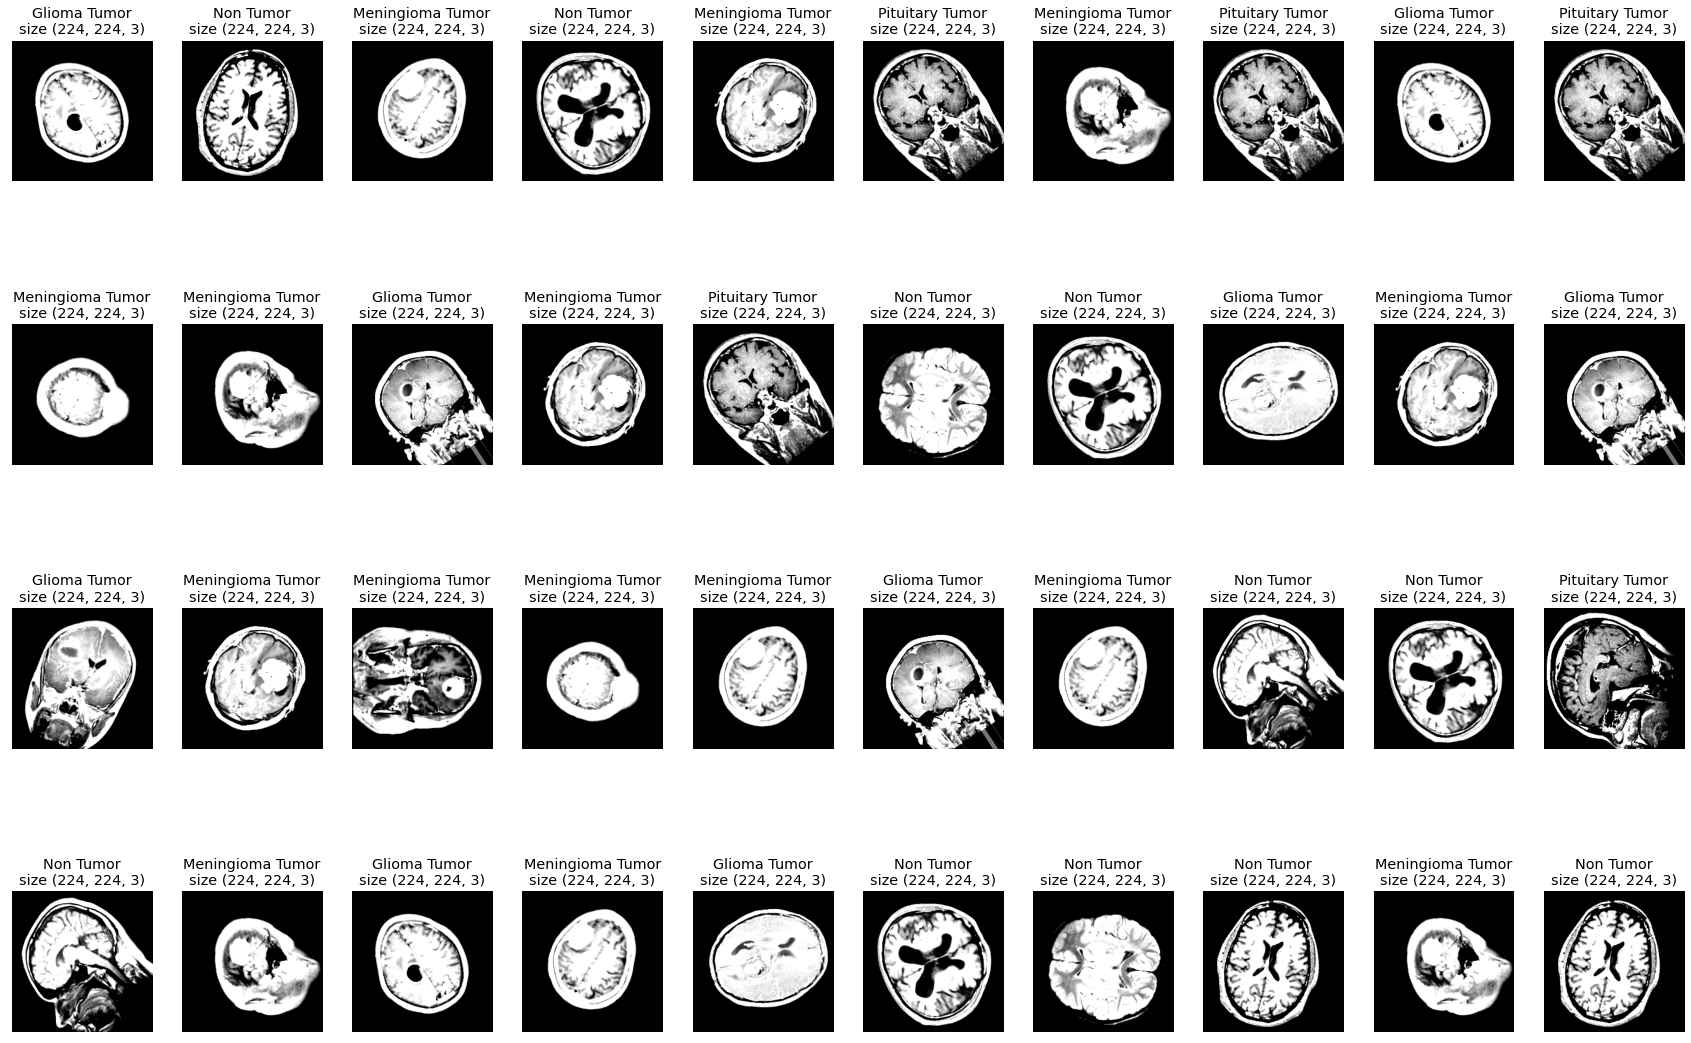

In [62]:
#converte labels to plot images
labels=[get_class(np.argmax(i)) for i in train_labels]

#show train generator
image_show(train_scans,labels,40)

**all is done data prepareation and data preprocessing  on scans and labels**

# Build Models

EfficientNetB3 and densenet169


# denenet_model

In [63]:
denenet_model=DenseNet201(weights="imagenet", include_top=False , input_shape=(ImageSize,ImageSize,3) )


for layer in denenet_model.layers[:150]:
    layer.trainable=False
    
    
# denenet_model.summary()




# Fine tuning  dense net model model

x=Flatten()(denenet_model.output)
x=Dense(1024, activation="relu")(x)
x=Dense(1024, activation="relu")(x)

x=Dense(512, activation="relu")(x)
x=Dense(512, activation="relu")(x)

x=Dense(256, activation="relu")(x)
x=Dense(256, activation="relu")(x)

x=Dense(128, activation="relu")(x)

x=Dense(64, activation="relu")(x)

output=Dense(4, activation="softmax")(x)

model=Model(inputs=denenet_model.input , outputs=output)
model.summary()

#plot model
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True , to_file="model.png")

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

conv5_block19_2_conv (Conv2D)   (None, 7, 7, 32)     36864       conv5_block19_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block19_concat (Concatena (None, 7, 7, 1504)   0           conv5_block18_concat[0][0]       
                                                                 conv5_block19_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block20_0_bn (BatchNormal (None, 7, 7, 1504)   6016        conv5_block19_concat[0][0]       
__________________________________________________________________________________________________
conv5_block20_0_relu (Activatio (None, 7, 7, 1504)   0           conv5_block20_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block20_1_conv (Conv2D)   (None, 7, 7, 128)    192512      conv5_block20_0_relu[0][0]       
__________

KeyboardInterrupt: 

In [ ]:
#callbacks
callbacks_denseNet=[
    tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=5 , verbose=1),
    tf.keras.callbacks.ModelCheckpoint("denseNetModel.h5" , save_best_only=True)
    ]

In [ ]:
#training Densenet Model

# check t batch size is 32
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001 ,  epsilon=1e-07) , 
              loss=tf.keras.losses.categorical_crossentropy , 
              metrics=["accuracy"])

DenseNet_history=model.fit(train_generator, 
          epochs=20  , 
          steps_per_epoch=x_train.shape[0]/batch_size ,
          validation_data=val_generator ,callbacks=callbacks_denseNet,
          verbose=1)

#evaluate 
print('evaluate')
model.evaluate(train_generator),model.evaluate(val_generator)

In [ ]:
print("- the Accuracy and Loss for DenseNet Model With 20 Epochs")
plt.figure(figsize=(40,20))
# summarize history for accuracy 
plt.subplot(5,5,1)
plt.plot(DenseNet_history.history['accuracy'])
plt.plot(DenseNet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')



# summarize history for loss
plt.subplot(5,5,2)
plt.plot(DenseNet_history.history['loss'])
plt.plot(DenseNet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','loss'], loc='upper left')
plt.show()

In [ ]:
#class activation map

# cam_model=Model(inputs=model.input, outputs=(model.layers))

# EfficientNetB3_model

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_12 (Rescaling)        (None, 224, 224, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
normalization_12 (Normalization (None, 224, 224, 3)  7           rescaling_12[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_12[0][0]           
______________________________________________________________________________________

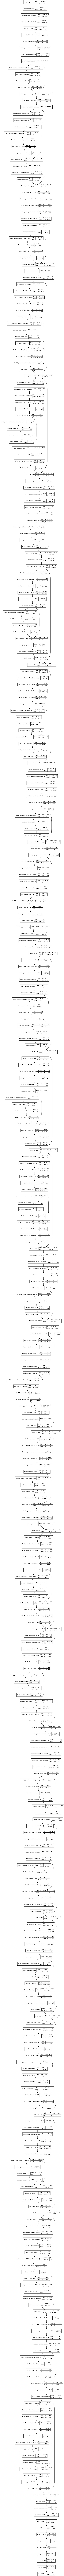

In [102]:
# call EfficientNetB3  model

EfficientNetB3_model=EfficientNetB3(weights="imagenet", include_top=False , input_shape=(ImageSize,ImageSize,3) )


for layer in EfficientNetB3_model.layers[:10]: # after 30
    layer.trainable=False
    
    
# EfficientNetB3_model.summary()
# connect two models with together
# inputs=Input(shape=(ImageSize,ImageSize,3))
# x=EfficientNetB3_model.input

x=Flatten()(EfficientNetB3_model.output)
x=Dense(1024, activation="relu")(x)
# x=Dense(1024, activation="relu")(x)
# x=Dense(1024, activation="relu")(x)
# x=Dense(1024, activation="relu")(x)

x=Dropout(0.3)(x)
x=Dense(512, activation="relu")(x)
# x=Dense(512, activation="relu")(x)
# x=Dense(512, activation="relu")(x)
x=Dropout(0.2)(x)
x=Dense(256, activation="relu")(x)
# x=Dense(256, activation="relu")(x)
x=Dense(128, activation="relu")(x)
x=Dense(64, activation="relu")(x)
output=Dense(4, activation="softmax")(x)

EfficientNetB3_model=Model(inputs=EfficientNetB3_model.input , outputs=output)
EfficientNetB3_model.summary()

#plot model
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(EfficientNetB3_model, show_shapes=True, show_layer_names=True , to_file="model.png")


In [ ]:
len(EfficientNetB3_model.layers)

In [ ]:
# cam_model=EfficientNetB3_model(inputs=EfficientNetB3_model.input , outputs=(EfficientNetB3_model.))

In [95]:
#callbacks
callbacks_EfficientNetB3=[
    tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=5 , verbose=1),
    tf.keras.callbacks.ModelCheckpoint("EfficientNetB3.h5" , save_best_only=True)
    ]

In [103]:
# training EfficientNetB3 model
EfficientNetB3_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001 ,  epsilon=1e-07) , 
              loss=tf.keras.losses.categorical_crossentropy , 
              metrics=["accuracy"])


EfficientNetB3_history=EfficientNetB3_model.fit(
          train_generator, 
          epochs=20  , 
          steps_per_epoch=x_train.shape[0]/batch_size ,
          validation_data=val_generator ,callbacks=callbacks_EfficientNetB3,
          verbose=1)

Epoch 1/20
177/176 [==============================] - 50s 285ms/step - loss: 0.6700 - accuracy: 0.7410 - val_loss: 2.2816 - val_accuracy: 0.1812
Epoch 2/20
177/176 [==============================] - 47s 265ms/step - loss: 0.3749 - accuracy: 0.8624 - val_loss: 1.3274 - val_accuracy: 0.4832
Epoch 3/20
177/176 [==============================] - 47s 268ms/step - loss: 0.2792 - accuracy: 0.9092 - val_loss: 0.4044 - val_accuracy: 0.8523
Epoch 4/20
177/176 [==============================] - 47s 267ms/step - loss: 0.1948 - accuracy: 0.9393 - val_loss: 0.1565 - val_accuracy: 0.9597
Epoch 5/20
177/176 [==============================] - 48s 271ms/step - loss: 0.1651 - accuracy: 0.9429 - val_loss: 0.1975 - val_accuracy: 0.9463
Epoch 6/20
177/176 [==============================] - 47s 266ms/step - loss: 0.1573 - accuracy: 0.9507 - val_loss: 0.1107 - val_accuracy: 0.9597
Epoch 7/20
177/176 [==============================] - 48s 273ms/step - loss: 0.1085 - accuracy: 0.9606 - val_loss: 0.2194 - val_ac

- the Accuracy and Loss for EfficientNetB3 Model With 20 Epochs


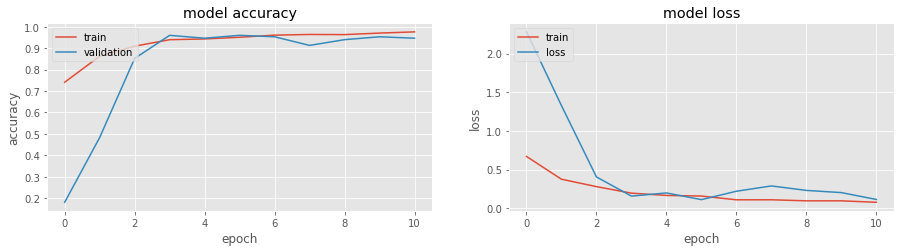

In [105]:
print("- the Accuracy and Loss for EfficientNetB3 Model With 20 Epochs")
plt.figure(figsize=(40,20))

# summarize history for accuracy
plt.subplot(5,5,1)
plt.plot(EfficientNetB3_history.history['accuracy'])
plt.plot(EfficientNetB3_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')


# summarize history for loss
plt.subplot(5,5,2)
plt.plot(EfficientNetB3_history.history['loss'])
plt.plot(EfficientNetB3_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','loss'], loc='upper left')
plt.show()

In [104]:
EfficientNetB3_model.evaluate(train_generator),EfficientNetB3_model.evaluate(val_generator)

5/5 [==============================] - 2s 332ms/step - loss: 0.0909 - accuracy: 0.9530


([0.023028923198580742, 0.9914863705635071],
 [0.0909021645784378, 0.9530201554298401])

In [ ]:
#to download output files 
import os
os.chdir(r'../working')
from IPython.display import FileLink
FileLink(r'./denseNetModel.h5')         ,FileLink(r'./EfficientNetB3.h5')                                                                

In [ ]:
#to download output files 
import os
os.chdir(r'../working')
from IPython.display import FileLink
FileLink(r'./denseNetModel.h5')  